#### Script destiné à récupérer toutes les données de production d'électricité depuis 2015

In [34]:
import json
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import pytz

In [35]:
client_id = "ac96732a-51ba-4487-91ee-755f22119c52"
client_secret = "12640de5-1bdf-411e-bc9d-905776c3557e"
url = "https://digital.iservices.rte-france.com/token/oauth/"


In [36]:
#data_rte = open('/Users/lucius/ProjPython2A/data_rte.csv','w',newline='')
#writer = csv.writer(data_rte)

In [37]:
def get_access_token(url, client_id, client_secret):
    response = requests.post(
        url,
        data={"grant_type": "client_credentials"},
        auth=(client_id, client_secret),
    )
    return response.json()["access_token"]


myToken = get_access_token(url, client_id, client_secret)

In [56]:
#On définit plusieurs fonctions pour simplifier les conditions sur le code

#fonction pour écrire les mois avec 0
def f(x):
    if len(x)<2:
        x = "0" + x
    return x

#fonction pour faire
def caract(deb_mois,deb_annees):
    fin_annees = deb_annees
    deb_mois = f(deb_mois)
    fin_mois = str(int(deb_mois)+1)
    fin_mois=f(fin_mois)
    if int(fin_mois)>12: # Janvier de l'année d'après
        fin_mois = "01"
        fin_annees=str(int(deb_annees)+1)
    return deb_mois, deb_annees, fin_mois, fin_annees

x,y,z,t=caract('12','2022')

print(x, y , z, t)



12 2022 01 2023


In [59]:

# 15/12/2014 début des données de l'API



base_url = "https://digital.iservices.rte-france.com/open_api/actual_generation/v1/actual_generations_per_production_type?"

#on crée un dataframe vide auquel on va append les données RTE 
df = pd.DataFrame(columns = ['start_date', 'end_date', 'value'])

for i in range(2015,2023): 
    for j in range(1,13):
        #boucle sur les dates

        deb_mois = str(j)
        deb_annees = str(i)
        deb_mois,deb_annees, fin_mois, fin_annees = caract(deb_mois, deb_annees)
        
        #On brise la boucle pour le mois de décembre 2022 (données non disponibles)
        if deb_mois == "12" and deb_annees=="2022" :
            break
        

        #configuration URL API

        start_date = deb_annees + "-" + deb_mois + "-01T00:00:00%2B02:00"
        end_date = fin_annees + '-' + fin_mois + "-01T00:00:00%2B02:00" 
        complete_url = base_url + "start_date=" + start_date + "&end_date=" + end_date 

        #authentification

        head = {'Authorization': 'Bearer {}'.format(myToken)}
        response = requests.get(complete_url, headers=head)

        #formatage des données; de JSON à un dataframe
        json2 = response.json()
        df_rte = pd.json_normalize(json2['actual_generations_per_production_type'][10], 'values')
        df_rte['end_date'] = pd.to_datetime(df_rte['end_date'])
        df_rte['start_date'] = pd.to_datetime(df_rte['start_date'])

        #on merge les dataframes par les lignes
        df = [df, df_rte]
        df = pd.concat(df)



df.head()

,start_date,end_date,value,updated_date
0,2015-01-01 00:00:00+01:00,2015-01-01 01:00:00+01:00,1314,NaN
1,2015-01-01 01:00:00+01:00,2015-01-01 02:00:00+01:00,1383,NaN
2,2015-01-01 02:00:00+01:00,2015-01-01 03:00:00+01:00,1464,NaN
3,2015-01-01 03:00:00+01:00,2015-01-01 04:00:00+01:00,1543,NaN
4,2015-01-01 04:00:00+01:00,2015-01-01 05:00:00+01:00,1579,NaN


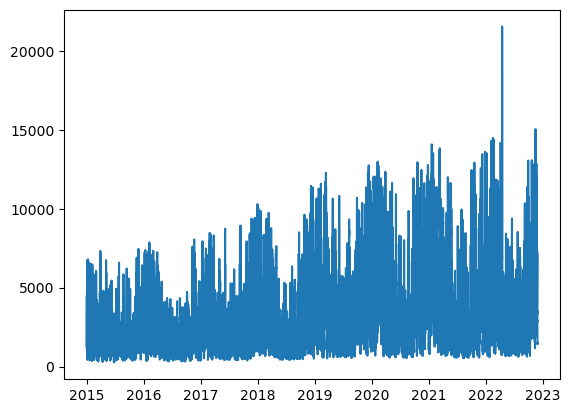

In [60]:
len(df)
plt.plot(df['end_date'],df['value'])


In [28]:

print(df['end_date'])

df['end_date].tzinfo()


SyntaxError: EOL while scanning string literal (737410832.py, line 6)

In [61]:

#on convertit nos heures UTC en heures françaises pour que les heures correspondent aux heures françaises de l'API des vents.


#on souhaite réaliser des plots avec moyennes mensuelles et annuelles


In [62]:
#ici on convertit les dates au format UTC pour pouvoir les convertir au format date, cela n'aura pas d'incidence sur les moyennes mensuelles et annuelles.
df['end_date'] = pd.to_datetime(df['end_date'], utc=True)


In [63]:
#On les met au 
df = df.set_index('end_date')
df.head()



,start_date,value,updated_date
end_date,,,
2015-01-01 00:00:00+00:00,2015-01-01 00:00:00+01:00,1314,NaN
2015-01-01 01:00:00+00:00,2015-01-01 01:00:00+01:00,1383,NaN
2015-01-01 02:00:00+00:00,2015-01-01 02:00:00+01:00,1464,NaN
2015-01-01 03:00:00+00:00,2015-01-01 03:00:00+01:00,1543,NaN
2015-01-01 04:00:00+00:00,2015-01-01 04:00:00+01:00,1579,NaN


/var/folders/n5/3cv0cz914xgbz9ghnnt5my_c0000gn/T/ipykernel_49689/2272723780.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df.resample('M').mean().plot()
/var/folders/n5/3cv0cz914xgbz9ghnnt5my_c0000gn/T/ipykernel_49689/2272723780.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df.resample('Y').mean().plot()


<AxesSubplot:xlabel='end_date'>

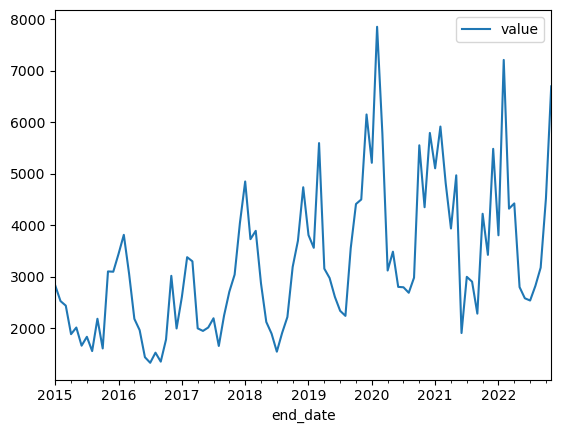

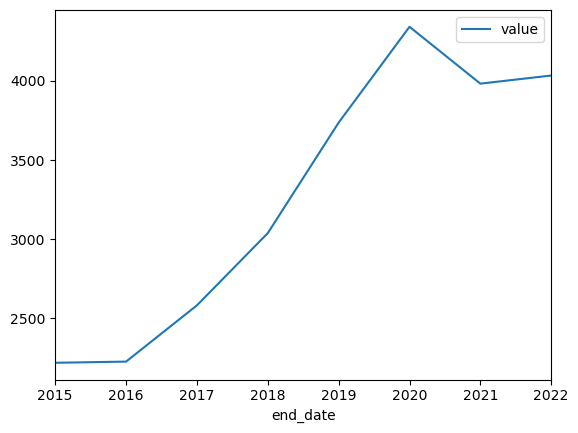

In [64]:
#On obtient les graphiques de moyennes mensuelles et annuelles
df.resample('M').mean().plot()
df.resample('Y').mean().plot()

In [ ]:




#je laisse start et end mais bien garder en tête l'intervalle de temps

#Ce qu'il reste à faire :
#afficher la série temp et variations infra/semaines/mois/saisons

#intermittence du vent et de l'énergie 

,start_date,end_date,value
0,2015-06-08 00:00:00+02:00,2015-06-08 01:00:00+02:00,3673
1,2015-06-08 01:00:00+02:00,2015-06-08 02:00:00+02:00,3624
2,2015-06-08 02:00:00+02:00,2015-06-08 03:00:00+02:00,3623
3,2015-06-08 03:00:00+02:00,2015-06-08 04:00:00+02:00,3707
4,2015-06-08 04:00:00+02:00,2015-06-08 05:00:00+02:00,3661
5,2015-06-08 05:00:00+02:00,2015-06-08 06:00:00+02:00,3534
6,2015-06-08 06:00:00+02:00,2015-06-08 07:00:00+02:00,3396
7,2015-06-08 07:00:00+02:00,2015-06-08 08:00:00+02:00,3114
8,2015-06-08 08:00:00+02:00,2015-06-08 09:00:00+02:00,3071
9,2015-06-08 09:00:00+02:00,2015-06-08 10:00:00+02:00,3355
